In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

from architectures import SRCNN, ESPCNN, EDSR, MDSR, RCAN, MRCAN, SharpeningModule
from readings import openImage

We need to introduce several simple functions, which show given images, convert between instanse of `PIL.Image` and `torch.tensor` and rescale given images

In [2]:
def show_images(images):
    fig, axis = plt.subplots(1, len(images), figsize = [10, 10])
    for i in range(len(images)):
        axis[i].imshow(images[i])

def tensored(image):
    im = ToTensor()(image)
    im = im.view([1] + list(im.size()))
    return im

def imaged(tensor):
    im = tensor.view(tensor.size()[1:])
    im = ToPILImage()(im)
    return im

def scale2(image):
    im = image.resize(
        (image.size[0] * 2, image.size[1] * 2),
        Image.BICUBIC)
    return im

def degrade(image, scale):
    im = image.resize(
        (image.size[0] // scale, image.size[1] // scale),
        Image.NEAREST)
    return im

## Single-scale models on Div2k dataset

We demonstrate the work of single-scale models, trained on div2k dataset on this image

In [3]:
div2k_image_low = openImage("images/building_low.png")
div2k_image_low = div2k_image_low.crop((125, 250, 175, 300))
div2k_image = openImage("images/building.png")
div2k_image = div2k_image.crop((500, 1000, 700, 1200)).resize((100, 100), Image.LANCZOS)

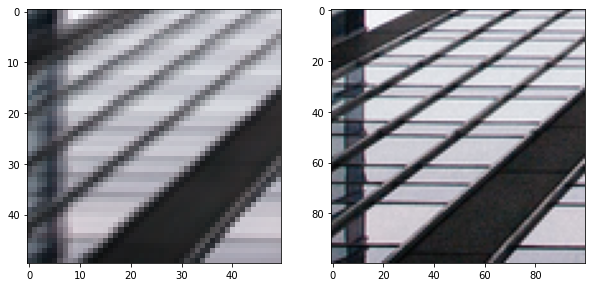

In [4]:
show_images([div2k_image_low, div2k_image])

In [5]:
device = torch.device("cuda:0")

Folder `div2k` contains the parameters of all the models, and the output for different images from *Div2k* validation set for each model and the comparison of all single-scale models

SRCNN requires to scale input image by a factor of 2 with bicubic interpolation, all the next model accept low-resolution image without scaling

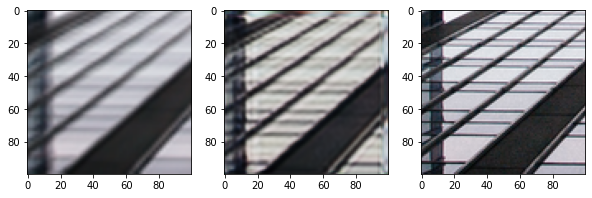

In [6]:
srcnn = SRCNN()
srcnn.load_state_dict(torch.load("div2k/parameters/srcnn_parameters.pth"))
srcnn.to(device)
srcnn.eval()
with torch.no_grad():
    image = scale2(div2k_image_low)
    superres = srcnn(tensored(image).to(device))
show_images([image, imaged(superres.cpu()), div2k_image])

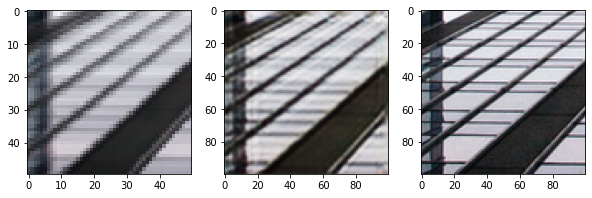

In [7]:
espcnn = ESPCNN()
espcnn.load_state_dict(torch.load("div2k/parameters/espcnn_parameters.pth"))
espcnn.to(device)
espcnn.eval()
with torch.no_grad():
    image = div2k_image_low
    superres = espcnn(tensored(image).to(device))
show_images([image, imaged(superres.cpu()), div2k_image])

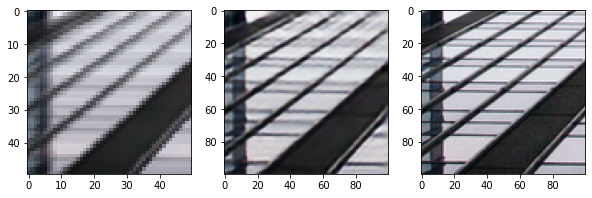

In [8]:
edsr = EDSR()
edsr.load_state_dict(torch.load("div2k/parameters/edsr_parameters.pth"))
edsr.to(device)
edsr.eval()
with torch.no_grad():
    image = div2k_image_low
    superres = edsr(tensored(image).to(device))
show_images([image, imaged(superres.cpu()), div2k_image])

## Sharpening

We also introduce sharpening module, which has 2 types  
`unblurring` substracts the blurred version of an image from this image  
`addition` applies the sharpening kernel to all of image channels

The sharpening can be applied to the output of any model

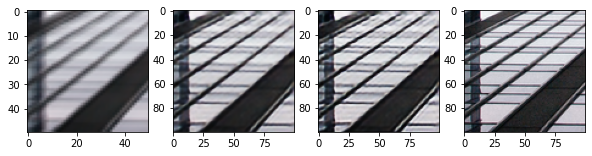

In [9]:
edsr_output = superres
sharp = SharpeningModule("unblurring")
sharp.to(device)
superres = sharp(edsr_output)
show_images([image, imaged(edsr_output.cpu()), imaged(superres.cpu()), div2k_image])